**Import Packages and Collect Data**

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Conv2D, LSTM, Bidirectional, Dense, Flatten, MultiHeadAttention, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from sklearn.metrics import pairwise_distances
from scipy.optimize import minimize

# Define sector ETFs
etfs = ["XLF", "XLK", "XLE", "XLY", "XLP", "XLV", "XLI", "XLU", "XLRE", "XLB"]
start_train, end_train = "2017-01-01", "2020-12-31"
start_test, end_test = "2021-01-01", "2023-12-31"

# Fetch ETF data
def get_data(etfs, start, end):
    data = yf.download(etfs, start=start, end=end, auto_adjust=False)["Adj Close"]
    returns = data.pct_change().dropna()
    return returns

train_data = get_data(etfs, start_train, end_train)
test_data = get_data(etfs, start_test, end_test)

test_data.head()
train_data.head()

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed


Ticker,XLB,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
Date,,,,,,,,,,
2017-01-04,0.014603,-0.002100,0.008082,0.005912,0.003484,0.000000,0.012642,0.003715,0.007875,0.013312
2017-01-05,-0.002958,-0.002499,-0.010127,-0.002859,0.001634,0.003275,0.005121,0.001028,0.005115,-0.000723
2017-01-06,0.000989,0.000923,0.003410,0.005734,0.007341,0.000960,0.000000,0.003081,0.002827,0.004945
2017-01-09,-0.000197,-0.014495,-0.006797,-0.007760,-0.000203,-0.008058,-0.006369,-0.013107,0.004229,-0.000840
2017-01-10,0.000593,-0.009092,0.002139,0.004150,0.000203,-0.005029,-0.012500,-0.003112,0.003509,0.003604


In [3]:
mean_returns = train_data.mean()
print(mean_returns)

Ticker
XLB     0.000554
XLE    -0.000259
XLF     0.000435
XLI     0.000532
XLK     0.001159
XLP     0.000422
XLRE    0.000397
XLU     0.000470
XLV     0.000617
XLY     0.000810
dtype: float64


**Compute Covariance Matrices of Returns**

In [4]:
# Compute normalized covariance matrices (correlation matrices)
def compute_covariance_matrices(data, window=30):
    cov_matrices = []
    for i in range(len(data) - window):
        window_data = data.iloc[i:i+window]
        cov_matrix = np.cov(window_data, rowvar=False)
        
        # Normalize to correlation matrix
        std_devs = np.sqrt(np.diag(cov_matrix))  # Standard deviations
        corr_matrix = cov_matrix / np.outer(std_devs, std_devs)  # Normalize
        
        cov_matrices.append(corr_matrix)
    return np.array(cov_matrices)

train_cov = compute_covariance_matrices(train_data)
test_cov = compute_covariance_matrices(test_data)

# Reshape for CNN input
train_cov = train_cov[..., np.newaxis]
test_cov = test_cov[..., np.newaxis]

train_cov[0]

array([[[ 1.        ],
        [ 0.50920136],
        [ 0.55484874],
        [ 0.55801257],
        [ 0.57680767],
        [ 0.01583364],
        [ 0.17924775],
        [ 0.00203674],
        [-0.12762141],
        [ 0.61289613]],

       [[ 0.50920136],
        [ 1.        ],
        [ 0.4527448 ],
        [ 0.49228539],
        [ 0.34671291],
        [ 0.50193632],
        [ 0.4566601 ],
        [ 0.39901004],
        [-0.10943984],
        [ 0.4617063 ]],

       [[ 0.55484874],
        [ 0.4527448 ],
        [ 1.        ],
        [ 0.79896328],
        [ 0.68640599],
        [-0.01562221],
        [-0.07934898],
        [-0.20187395],
        [ 0.21723759],
        [ 0.44310758]],

       [[ 0.55801257],
        [ 0.49228539],
        [ 0.79896328],
        [ 1.        ],
        [ 0.66396268],
        [ 0.02032947],
        [-0.09878416],
        [-0.07874586],
        [-0.00524001],
        [ 0.4674485 ]],

       [[ 0.57680767],
        [ 0.34671291],
        [ 0.68640599],
   

**Train Optimal Allocations with Markowitz?**

In [5]:
# Compute Markowitz Optimal Allocations for each window in the training set
def compute_markowitz_allocations(data, window=30):
    optimal_allocations = []
    for i in range(len(data) - window):
        window_data = data.iloc[i:i+window]
        mean_returns = window_data.mean()
        cov_matrix = window_data.cov()

        # Perform Markowitz optimization to get optimal portfolio allocation
        optimal_allocation = markowitz_optimization(mean_returns, cov_matrix)
        optimal_allocations.append(optimal_allocation)

    return np.array(optimal_allocations)

# Compute optimal allocations for the training set
train_optimal_allocations = compute_markowitz_allocations(train_data)

NameError: name 'markowitz_optimization' is not defined

In [60]:
train_optimal_allocations[88]

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

**Use Sharpe Ratio as the Loss Function**

In [ ]:
# Define Sharpe Ratio loss function
def sharpe_ratio_loss(y_true, y_pred):
    mean_returns = tf.reduce_mean(y_pred, axis=1)
    volatility = tf.math.reduce_std(y_pred, axis=1)
    sharpe_ratio = mean_returns / (volatility + 1e-6)
    return -sharpe_ratio  # Negative to maximize Sharpe

**HyperParameter Tuning**

In [ ]:
# Define hyperparameter search space
filters_list = [16, 32]
lstm_units_list = [32, 64]
attention_heads_list = [2, 4]
batch_sizes = [16, 32]
epochs_list = [30, 50]

best_loss = float('inf')
best_params = {}

# Loop over all hyperparameter combinations
for filters in filters_list:
    for lstm_units in lstm_units_list:
        for attention_heads in attention_heads_list:
            for batch_size in batch_sizes:
                for epochs in epochs_list:
                    print(f"Training with filters={filters}, LSTM={lstm_units}, Heads={attention_heads}, Batch={batch_size}, Epochs={epochs}")

                    # Define model
                    input_shape = train_cov.shape[1:]
                    inputs = tf.keras.Input(shape=input_shape)
                    x = Conv2D(filters, kernel_size=(3,3), activation='relu', padding='same')(inputs)
                    x = Flatten()(x)
                    x = Reshape((10, -1))(x)  # Reshape for BiLSTM
                    x = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
                    x = MultiHeadAttention(num_heads=attention_heads, key_dim=32)(x, x)
                    x = Flatten()(x)
                    outputs = Dense(10, activation='softmax')(x)  # Portfolio allocation

                    model = Model(inputs, outputs)
                    model.compile(optimizer='adam', loss=sharpe_ratio_loss)

                    # Train model
                    history = model.fit(train_cov, train_optimal_allocations, 
                                        epochs=epochs, batch_size=batch_size, 
                                        validation_split=0.1, verbose=0)

                    # Get final validation loss
                    val_loss = history.history['val_loss'][-1]

                    # Update best model if loss improves
                    if val_loss < best_loss:
                        best_loss = val_loss
                        best_params = {
                            "filters": filters,
                            "lstm_units": lstm_units,
                            "attention_heads": attention_heads,
                            "batch_size": batch_size,
                            "epochs": epochs
                        }

print(f"\nBest Hyperparameters: {best_params}, Best Loss: {best_loss}")

Training with filters=16, LSTM=32, Heads=2, Batch=16, Epochs=30
Training with filters=16, LSTM=32, Heads=2, Batch=16, Epochs=50
Training with filters=16, LSTM=32, Heads=2, Batch=32, Epochs=30
Training with filters=16, LSTM=32, Heads=2, Batch=32, Epochs=50
Training with filters=16, LSTM=32, Heads=4, Batch=16, Epochs=30
Training with filters=16, LSTM=32, Heads=4, Batch=16, Epochs=50
Training with filters=16, LSTM=32, Heads=4, Batch=32, Epochs=30
Training with filters=16, LSTM=32, Heads=4, Batch=32, Epochs=50
Training with filters=16, LSTM=64, Heads=2, Batch=16, Epochs=30
Training with filters=16, LSTM=64, Heads=2, Batch=16, Epochs=50
Training with filters=16, LSTM=64, Heads=2, Batch=32, Epochs=30
Training with filters=16, LSTM=64, Heads=2, Batch=32, Epochs=50
Training with filters=16, LSTM=64, Heads=4, Batch=16, Epochs=30


KeyboardInterrupt: 

**Final Model**

In [ ]:
# Define model architecture (unchanged)
input_shape = train_cov.shape[1:]
inputs = tf.keras.Input(shape=input_shape)
x = Conv2D(32, kernel_size=(3,3), activation='relu', padding='same')(inputs)
x = Flatten()(x)
x = Reshape((10, -1))(x)  # Reshape for BiLSTM processing
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
x = Flatten()(x)
outputs = Dense(10, activation='softmax')(x)  # Portfolio allocation

model = Model(inputs, outputs)

# Compile the model with the Sharpe ratio loss
model.compile(optimizer='adam', loss=sharpe_ratio_loss)

# Train the model
# Train the model with the actual optimal allocations (instead of dummy ones)
model.fit(train_cov, train_optimal_allocations, epochs=50, batch_size=32, validation_split=0.1)

# Predict allocations
pred_allocations = model.predict(test_cov)


Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 25s 49ms/step - loss: -39.4590 - val_loss: -16.2952
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: -56.1723 - val_loss: -26.9250
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: -53.9567 - val_loss: -38.5385
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: -42.8766 - val_loss: -29.7021
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: -22.7474 - val_loss: -36.5804
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: -54.7520 - val_loss: -12.4659
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: -12.4988 - val_loss: -14.5254
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: -15.6096 - val_loss: -21.6554
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: -32.0105 - val_loss: -19.2965
Epoch 10/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: -14.6377 - val_loss: -14.0451
Epoch 11/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: -17.3752 - val_loss: -55.3239
Epoch 12/50
28/28 

In [45]:
pred_allocations.shape

(722, 10)

**Plot the allocation for each ETF over time**

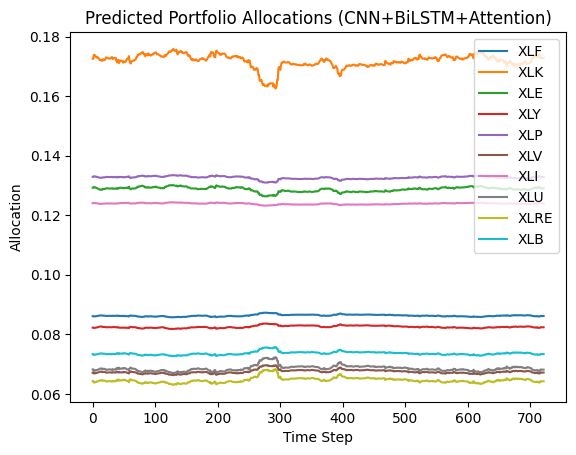

In [ ]:
# Plot the allocation for each ETF over time
for i in range(10):  # Loop over each ETF (0-9)
    plt.plot(pred_allocations[:, i], label=etfs[i])  # Plot for ETF[i]

plt.legend()
plt.title('Predicted Portfolio Allocations (CNN+BiLSTM+Attention)')
plt.xlabel('Time Step')
plt.ylabel('Allocation')
plt.show()


In [47]:
# Markowitz Optimization
mean_returns = test_data.mean()
cov_matrix = test_data.cov()

def markowitz_optimization(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    def objective(weights):
        return weights @ cov_matrix @ weights.T  # Minimize portfolio variance
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})  # Weights sum to 1
    bounds = [(0, 1) for _ in range(num_assets)]
    initial_weights = np.ones(num_assets) / num_assets
    result = minimize(objective, initial_weights, bounds=bounds, constraints=constraints)
    return result.x

markowitz_allocations = markowitz_optimization(mean_returns, cov_matrix)

In [48]:
# Evaluate performance
def compute_distances(pred, true):
    euclidean = np.linalg.norm(pred - true, axis=1).mean()
    frobenius = np.linalg.norm(pred - true, ord='fro') / len(pred)
    return euclidean, frobenius

euclidean_dist_pred, frobenius_dist_pred = compute_distances(pred_allocations, np.ones_like(pred_allocations) / 10)
euclidean_dist_markowitz, frobenius_dist_markowitz = compute_distances(pred_allocations, markowitz_allocations)

print(f'CNN+BiLSTM+Attention Model - Euclidean Distance: {euclidean_dist_pred}, Frobenius Distance: {frobenius_dist_pred}')
print(f'Markowitz Optimization - Euclidean Distance: {euclidean_dist_markowitz}, Frobenius Distance: {frobenius_dist_markowitz}')

CNN+BiLSTM+Attention Model - Euclidean Distance: 0.11010076105594635, Frobenius Distance: 0.004098845180124044
Markowitz Optimization - Euclidean Distance: 0.11010076572659319, Frobenius Distance: 0.004098845031659856


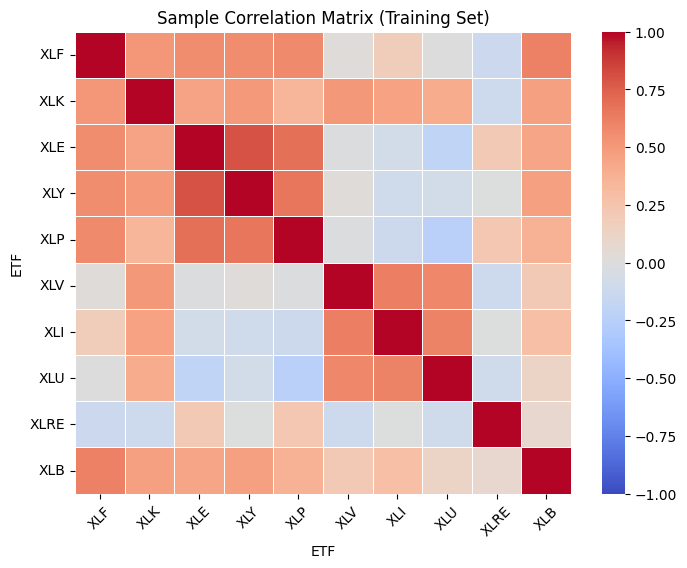

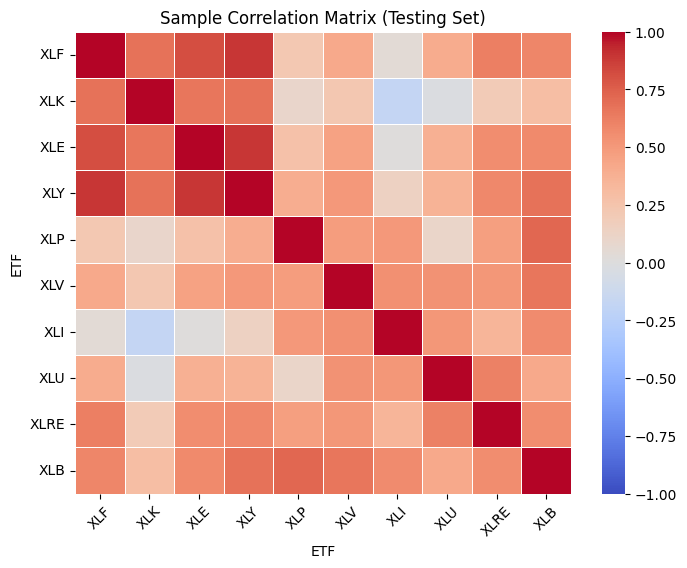

In [49]:
# Plot heatmap for correlation matrices
def plot_cov_matrix(cov_matrix, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cov_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5,
        xticklabels=etfs, yticklabels=etfs, vmin=-1, vmax=1  # Set ETF labels and fix color scale
    )
    plt.title(title)
    plt.xlabel("ETF")
    plt.ylabel("ETF")
    plt.xticks(rotation=45)  # Rotate labels for better visibility
    plt.yticks(rotation=0)
    plt.show()

# Select a sample from train and test
plot_cov_matrix(train_cov[0, :, :, 0], "Sample Correlation Matrix (Training Set)")
plot_cov_matrix(test_cov[0, :, :, 0], "Sample Correlation Matrix (Testing Set)")